# 🎮 스팀 게임 데이터 분석: 메타데이터 (Metadata Analysis)

## 🎯 분석 목표
- **게임 메타데이터** (장르 vs 태그)를 분석하여 추천 시스템의 Feature 전략 수립.
- **핵심 질문:**
    1. **결측률 (Sparsity):** 어떤 데이터가 더 꽉 차있는가? (장르 vs 태그)
    2. **다양성 (Cardinality):** 어떤 데이터가 더 구체적인 정보를 담고 있는가?

In [17]:
# ====== 1. 환경 설정 및 라이브러리 임포트 ======
import os
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# 출력 옵션 설정
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# .env 파일 로드 (환경변수)
load_dotenv()

# 데이터 경로 설정
DATA_PATH = '../../steam_data/now_steam/steam_games.json'
print(f"데이터 경로: {DATA_PATH}")

데이터 경로: ../../steam_data/now_steam/steam_games.json


In [18]:
# ====== 2. 데이터 로드 (Data Loading) ======
def load_steam_data(filepath):
    rows = []
    error_count = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                # 파일 형식이 엄격한 JSON이 아니라 Python 딕셔너리 문자열 형태임
                rows.append(ast.literal_eval(line.strip()))
            except (SyntaxError, ValueError):
                error_count += 1
                continue
    if error_count > 0:
        print(f"[주의] 파싱 에러로 {error_count} 라인을 건너뛰었습니다.")
    return pd.DataFrame(rows)

print("게임 데이터 로딩 중...")
games = load_steam_data(DATA_PATH)
print(f"로딩 완료: 총 {len(games):,} 개의 게임 데이터.")
games.head(3)

게임 데이터 로딩 중...
로딩 완료: 총 32,135 개의 게임 데이터.


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


## 📊 분석 1: 메타데이터 결측률 및 다양성 비교
**공식 장르(Genres)**와 **유저 태그(Tags)** 중 어떤 것을 Cold Start 문제 해결에 사용할지 결정합니다.

In [19]:
# ====== 3. Feature 분석: 결측률(Sparsity) & 다양성(Cardinality) ======

# 1. 메타데이터 추출
meta_df = games[['genres', 'tags']].copy()
total_len = len(meta_df)

# 2. 결측률 계산 (Sparsity)
null_counts = meta_df.isnull().sum()
sparsity_pct = (null_counts / total_len) * 100

print("\n[1] 결측률 확인 (Sparsity Check)")
print(f"- 결측 장르 (Genres): {null_counts['genres']:,} 개 ({sparsity_pct['genres']:.2f}% 결측)")
print(f"- 결측 태그 (Tags):   {null_counts['tags']:,} 개   ({sparsity_pct['tags']:.2f}% 결측)")

# 3. 다양성 계산 (Unique Values)
all_genres = set()
for g_list in meta_df['genres'].dropna():
    all_genres.update(g_list)

all_tags = set()
for t_list in meta_df['tags'].dropna():
    all_tags.update(t_list)

print("\n[2] 다양성 확인 (Cardinality Check)")
print(f"- 고유 장르 수: {len(all_genres):,} 개")
print(f"- 고유 태그 수: {len(all_tags):,} 개")
if len(all_genres) > 0:
    print(f"- 구체성 비율: {len(all_tags)/len(all_genres):.1f}배 (태그가 장르보다 훨씬 구체적임)")


[1] 결측률 확인 (Sparsity Check)
- 결측 장르 (Genres): 3,283 개 (10.22% 결측)
- 결측 태그 (Tags):   163 개   (0.51% 결측)

[2] 다양성 확인 (Cardinality Check)
- 고유 장르 수: 22 개
- 고유 태그 수: 339 개
- 구체성 비율: 15.4배 (태그가 장르보다 훨씬 구체적임)


In [20]:
# ====== 4. 하이브리드 결측치 보완 전략 (Imputation) ======
# 로직: 공식 장르가 비어있다면, 태그 정보를 활용하여 채워넣는다.

def impute_genre(row):
    # 1. 이미 장르가 있다면 유지
    if isinstance(row['genres'], list):
        return row['genres']
    
    # 2. 장르가 없고 태그가 있다면, 태그에서 추론
    if isinstance(row['tags'], list):
        # 태그 중 공식 장르 목록에 포함된 것만 추출
        inferred = [tag for tag in row['tags'] if tag in all_genres]
        if inferred:
            return inferred
            
    return row['genres']

print(f"보완 전 결측 장르 수: {meta_df['genres'].isnull().sum()}")
meta_df['genres_filled'] = meta_df.apply(impute_genre, axis=1)
print(f"보완 후 결측 장르 수: {meta_df['genres_filled'].isnull().sum()}")

recovered = meta_df['genres'].isnull().sum() - meta_df['genres_filled'].isnull().sum()
print(f"성공적으로 복구된 게임 수: {recovered} 개 (태그 활용)")

보완 전 결측 장르 수: 3283
보완 후 결측 장르 수: 1031
성공적으로 복구된 게임 수: 2252 개 (태그 활용)


## 💡 핵심 발견 (Key Findings)
- **태그(Tags)**가 콘텐츠 기반 필터링에 더 적합함.
- **이유:** 
    1. 낮은 결측률 (0.5% vs 10.2%)
    2. 높은 구체성 (장르 대비 15.4배 더 상세함)

## 📊 분석 2: 장르 및 태그 분포 상세 분석 (Distribution Analysis)
**Word Cloud**와 **Bar Plot**을 통해 어떤 장르와 태그가 가장 지배적인지 시각적으로 확인합니다.

In [21]:
# 라이브러리 임포트 (WordCloud)
from wordcloud import WordCloud
from collections import Counter

# 1. 멀티라벨 데이터 분리 (Explode)
# 모든 장르와 태그를 하나의 리스트로 펼칩니다.
all_genres_list = [g for genres in games['genres'].dropna() for g in genres]
all_tags_list = [t for tags in games['tags'].dropna() for t in tags]

genre_counts = Counter(all_genres_list)
tag_counts = Counter(all_tags_list)

print(f"총 장르 출현 횟수: {sum(genre_counts.values()):,}")
print(f"총 태그 출현 횟수: {sum(tag_counts.values()):,}")

총 장르 출현 횟수: 71,554
총 태그 출현 횟수: 169,229


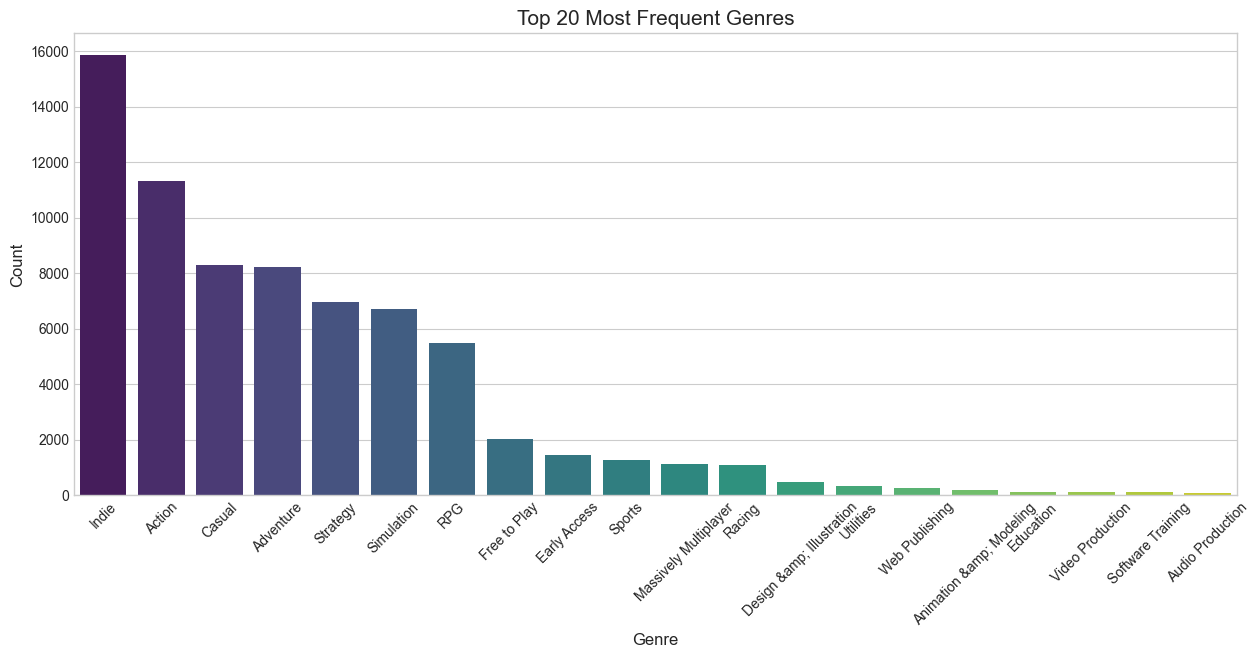

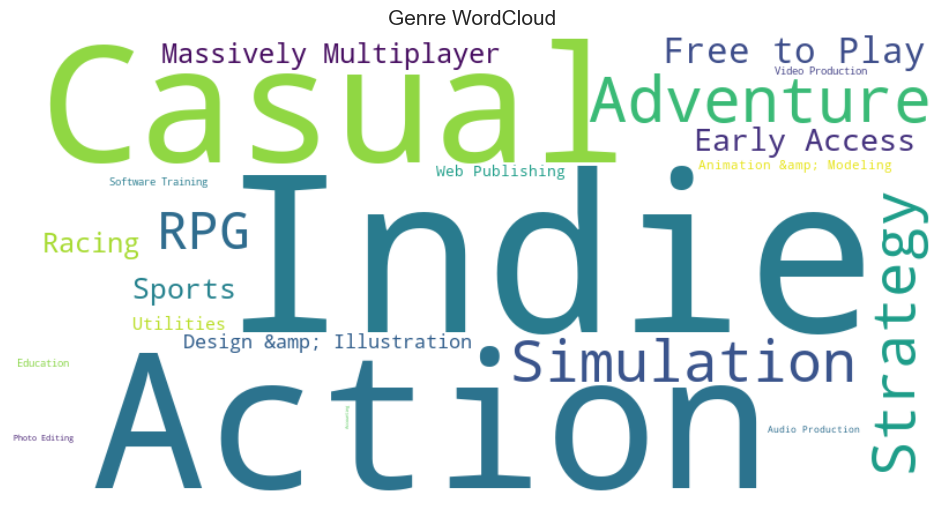

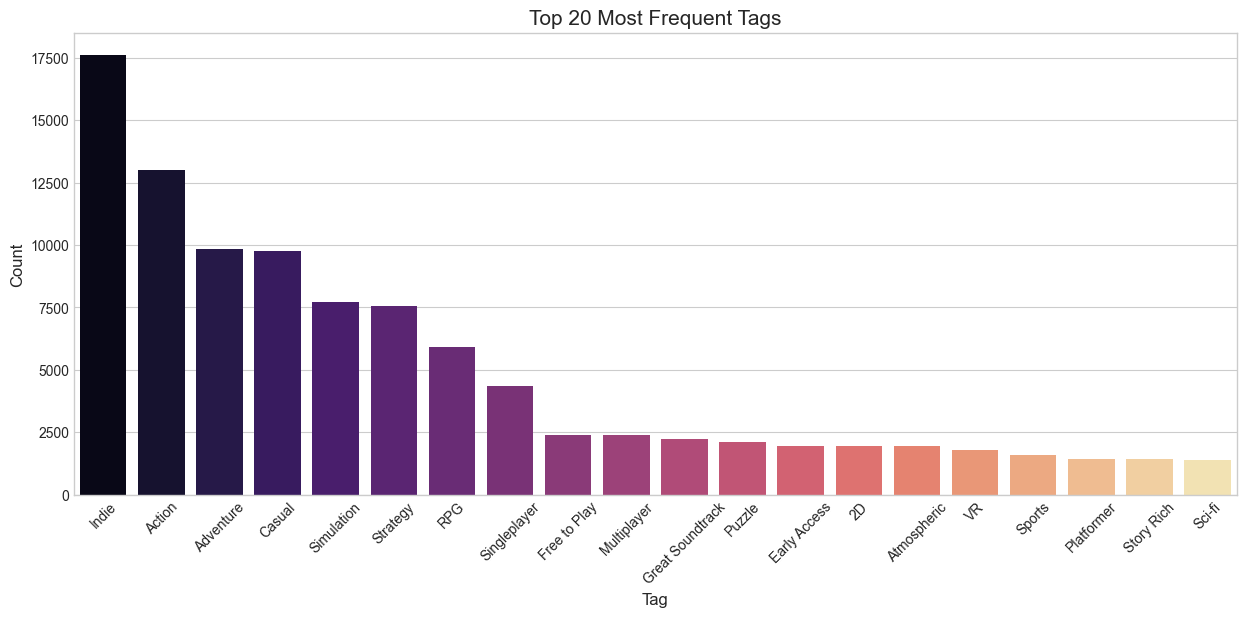

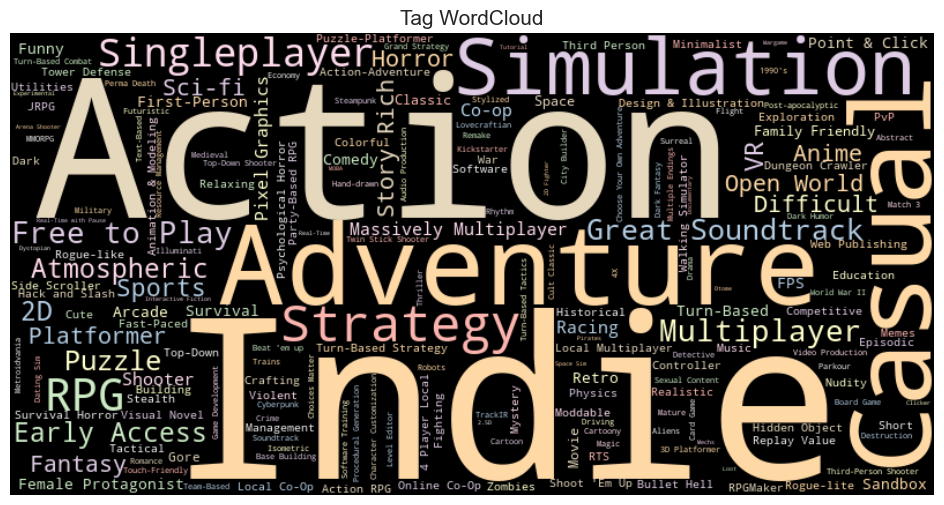

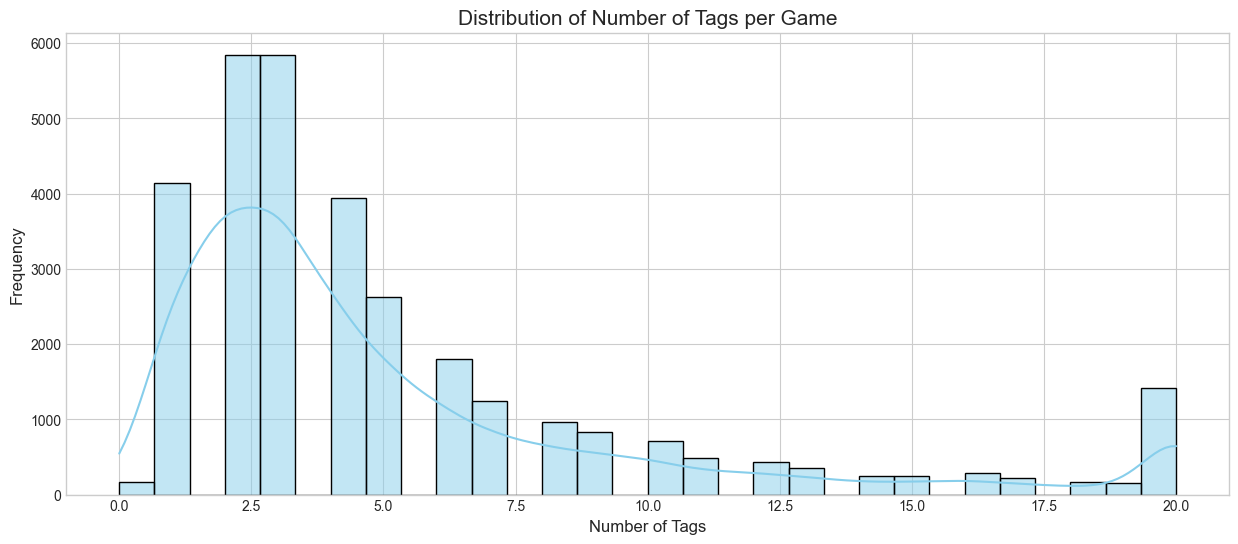

In [22]:
# 2. 장르 빈도 Top 20 시각화 (Bar Plot)
sorted_genres = dict(genre_counts.most_common(20))

plt.figure(figsize=(15, 6))
# Fix FutureWarning: assign x to hue and set legend=False
sns.barplot(x=list(sorted_genres.keys()), y=list(sorted_genres.values()), hue=list(sorted_genres.keys()), legend=False, palette='viridis')
plt.title('Top 20 Most Frequent Genres', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.savefig('assets/genre_distribution_barplot.png')
plt.show()

# 3. 장르 WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre WordCloud', fontsize=15)
plt.savefig('assets/genre_wordcloud.png')
plt.show()

# 4. 태그 빈도 Top 20 시각화 (Bar Plot)
sorted_tags = dict(tag_counts.most_common(20))

plt.figure(figsize=(15, 6))
sns.barplot(x=list(sorted_tags.keys()), y=list(sorted_tags.values()), hue=list(sorted_tags.keys()), legend=False, palette='magma')
plt.title('Top 20 Most Frequent Tags', fontsize=15)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.savefig('assets/tag_distribution_barplot.png')
plt.show()

# 5. 태그 WordCloud
wordcloud_tags = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate_from_frequencies(tag_counts)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.title('Tag WordCloud', fontsize=15)
plt.savefig('assets/tag_wordcloud.png')
plt.show()

# 6. 게임별 태그 개수 분석
games['num_tags'] = games['tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
plt.figure(figsize=(15, 6))
sns.histplot(games['num_tags'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Number of Tags per Game', fontsize=15)
plt.xlabel('Number of Tags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('assets/tags_per_game_distribution.png')
plt.show()

plt.savefig('assets/genre_tag/genre_wordcloud.png')